# Neuronal Bursting

Final project about neuronal bursting for the course "Nonlinear Dynamics, Chaos and Application" by Jasper Pieterse

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.signal import find_peaks

## Code

### Constants

In [3]:
class Parameters:
    """Holds the model parameters"""
    C = 1
    I = 5
    g_L = 8
    g_Na = 20
    g_K = 9
    g_slow = 5
    E_L = -80
    E_Na = 60
    E_K = -90
    k_m = 15
    k_n = 5
    k_ns = 5
    V_half_m = -20
    V_half_n = -25
    V_half_ns = -20
    tau_n = 0.152
    tau_slow = 20

### Implementing the models

In [4]:
def f_inf(V: float, k: float, V_half: float) -> float:
    """Calculate the steady state value of activation variable."""
    return 1 / (1 + np.exp((V_half - V) / k))

def model(t: float, y0: np.ndarray, n_s = None) -> np.ndarray:
    """Model dynamics for neuronal burst with varying number of variables."""
    num_variables = len(y0)
    V, n = y0[:2]
    if num_variables == 3:
        n_s = y0[2]
    params = Parameters()
    
    m_inf = f_inf(V, params.k_m, params.V_half_m)
    n_inf = f_inf(V, params.k_n, params.V_half_n)
    
    dVdt = (params.I - params.g_L*(V-params.E_L) - params.g_Na*m_inf*(V-params.E_Na) - 
            params.g_K*n*(V-params.E_K) - params.g_slow*n_s*(V-params.E_K)) / params.C
    dn = (n_inf - n) / params.tau_n
    
    if num_variables == 2:
        return np.array([dVdt, dn])
    elif num_variables == 3:
        ns_inf = f_inf(V, params.k_ns, params.V_half_ns)
        dns = (ns_inf - n_s) / params.tau_slow
        return np.array([dVdt, dn, dns])
    else:
        raise ValueError("Invalid number of variables")

### Implementing the ODE's

As ODE integrators, we will use the improved Euler method and the library routine ```scipy_solve_ipv```:

In [5]:
def improved_euler_method(f, t, y0, dt, n_s):
    """Solve ODE using improved Euler method."""
    y = y0
    ys = [y0]
    for i in range(1, len(t)):
        y_predict = y + dt*f(t[i-1], y, n_s)
        y_correct = y + 0.5*dt*(f(t[i-1], y, n_s) + f(t[i], y_predict, n_s))
        y = y_correct
        ys.append(y)
    return np.array(ys)

def scipy_solution(f, t, y0, n_s):
    """Solve ODE using scipy library routine."""
    t_span = (t[0], t[-1])  # use the min and max of t as t_span
    sol = solve_ivp(f, t_span, y0, t_eval=t, args=(n_s,))
    return sol.y.T  # transpose to match the shape of improved euler output due to character limit

### Finding the ideal dt

We want to find the ideal time step ```dt``` (for a specific time range) to use for the improved euler method. This ideal time step will be dependent on the behavior of the solution over the time range we chose. We can write a brute-force function that finds the smallest absolute errorover a parameter sweep:

In [6]:
def find_optimal_dt(y0, t_range, dt_range, n_s = None):
    n_points = int((t_range[1]-t_range[0])/min(dt_range))
    t_eval = np.linspace(t_range[0], t_range[1], n_points)
    
    # solve with scipy ODE
    sol = solve_ivp(model, t_range, y0, t_eval=t_eval, args=(n_s,))
    ys_scipy = sol.y.T

    best_dt = None
    best_error = float('inf')

    # test each dt
    for dt in dt_range:
        t = np.arange(t_range[0], t_range[1] + dt, dt)
        
        # solve using improved Euler method
        ys_improved_euler = improved_euler_method(model, t, y0, dt, n_s)
        
        # interpolate the improved Euler solution at the same time points as the scipy solution
        interp_func = interp1d(t, ys_improved_euler, axis=0)
        ys_improved_euler_interp = interp_func(t_eval)

        # compute the mean absolute error
        error = np.mean(np.abs(ys_improved_euler_interp - ys_scipy))

        # update best dt if current error is lower
        if error < best_error:
            best_dt = dt
            best_error = error

    return best_dt

### Fixed points and nullcines

 The nullclines of the system are given by:

$$V^* = \frac{I + g_{Na}m_{\infty}(V)E_{Na} + g_K n E_K + g_{\text{slow}}n_s E_K + g_LE_L}{g_L + g_{Na}m_{\infty}(V) + g_Kn + g_{\text{slow}}n_s}$$
$$ n^* = n_{\infty}(V) $$



Fixed points are where the two nullclines intersect each other. Substituting the 2nd equation in the first gives us:

$$V^* = \frac{I + g_{Na} m_{\infty}(V^*) E_{Na} + g_K n_{\infty}(V^*) E_K + g_{\text{slow}}n_s E_K + g_LE_L}{g_L + g_{Na}m_{\infty}(V^*) + g_K n_{\infty}(V^*) + g_{\text{slow}}n_s}$$

All the $V^*$ that satisfy this equation are fixed points. We can't solve this analytically but we can do it numerically:


In [7]:
def calculate_fixed_points(n_s):
    def system_equations(y):
        V, n = y
        return model(0, [V, n], n_s)
    
    # Initial guess for fixed points
    V_guess = np.linspace(-70, 0, 10)
    n_guess = np.linspace(0, .5, 10)
    
    fixed_points = []

    # solve for fixed points using numerical root finding
    for V_initial in V_guess:
        for n_initial in n_guess:
            V_fixed, n_fixed = fsolve(system_equations, [V_initial, n_initial])

            # check if the fixed point satisfies the conditions
            dVdt, dn = model(0, [V_fixed, n_fixed], n_s)
            tolerance = 1e-6
            if np.abs(dVdt) < tolerance and np.abs(dn) < tolerance:
                    # check if the fixed point is already in the list (with some tolerance)
                    duplicate = False
                    for point in fixed_points:
                        V_existing, n_existing = point
                        if np.isclose(V_fixed, V_existing) and np.isclose(n_fixed, n_existing):
                            duplicate = True
                            break
                    if not duplicate:
                        fixed_points.append((V_fixed, n_fixed))

    return fixed_points

We can analyze the stability of the fixed points. The first method is using the trace and determinant. This method did not give correct results, so instead I opted to use a more robust method: the eigenvalues of the Jacobian matrix. The derivation of these is implemented using the sympy library.

In [8]:
def stability_analysis_old(V_fixed, n_fixed, n_s):
    params = Parameters()
    # compute m_inf and n_inf
    m_inf = f_inf(V_fixed, params.k_m, params.V_half_m)
    n_inf = f_inf(V_fixed, params.k_n, params.V_half_n)

    # calculate the elements of the Jacobian
    dV_dV = (params.g_L - params.g_Na * m_inf * (1 + params.k_m * (1 - m_inf) * (V_fixed - params.E_Na)) - params.g_K * n_fixed - params.g_slow * n_s) / params.C
    dV_dn = -params.g_K * (V_fixed - params.E_K)
    dn_dV = (1 / params.tau_n) * params.k_n * n_inf * (1 - n_inf)
    dn_dn = -1 / params.tau_n

    # calculate the trace and determinant
    Tr = dV_dV + dn_dn
    D  = dV_dV * dn_dn - dV_dn * dn_dV   

    return Tr, D

In [9]:
def f_inf_sp(V, k, V_half):
    """Helper function"""
    return 1 / (1 + sp.exp((V_half - V) / k))

def stability_analysis(V_fixed, n_fixed, ns_fixed):
    # declare the variables
    V, n = sp.symbols('V n')
    params = Parameters()

    # compute m_inf and n_inf
    m_inf = f_inf_sp(V, params.k_m, params.V_half_m)
    n_inf = f_inf_sp(V, params.k_n, params.V_half_n)
    
    # compute the rhs of the original system
    f = (params.I - params.g_L*(V-params.E_L) - params.g_Na*m_inf*(V-params.E_Na) - params.g_K*n*(V-params.E_K) - params.g_slow*ns_fixed*(V-params.E_K)) / params.C
    g = (n_inf - n) / params.tau_n

    # calculate the Jacobian matrix
    J = sp.Matrix([f, g]).jacobian([V, n])

    # substitute the fixed point values into the Jacobian
    J_at_fixed_point = J.subs({V: V_fixed, n: n_fixed})

    # compute the eigenvalues of the Jacobian
    eigenvalues = J_at_fixed_point.eigenvals()

    for value in eigenvalues:
        if value.has(sp.I):
            if sp.re(value) > 0:
                return ("Unstable spiral", "DarkOrange")
            elif sp.re(value) < 0:
                return ("Stable spiral", "Black")
            else:
                return ("Center", "Yellow")
        elif value > 0:
            return ("Sadle node", 'Gold')
        elif value < 0:
            return ("Stable node", 'ForestGreen')
        else:
            return ("Semi-stable FP", 'DeepPink')


### Calculating burst and spike rates (vs $n_s$)

In [10]:
def compute_burst_rate_and_spikes(model, y0, t_max, dt, spike_threshold, burst_threshold, n_s = None):
    # get time array
    t = np.arange(0, t_max, dt)

    # solve using scipy ODE
    sol = scipy_solution(model, t, y0, n_s).T
    V = sol[0]

    # detect spikes
    spikes, _ = find_peaks(V, height=spike_threshold)

    if len(spikes) == 0:  # no spikes detected
        return 0, 0, 0
    
    # detect bursts and count spikes per burst
    bursts = []
    spike_count = []
    burst_start = spikes[0]  # start of the first burst
    count = 1
    for i in range(1, len(spikes)):
        if t[spikes[i]] - t[spikes[i - 1]] > burst_threshold:
            bursts.append([burst_start, spikes[i - 1]])  # append the start and end of the burst
            burst_start = spikes[i]  # start of the next burst
            spike_count.append(count)
            count = 1
        else:
            count += 1
    spike_count.append(count)  # append the spike count of the last burst

    # compute burst rate and average spikes per burst
    burst_rate = len(bursts) / t_max if bursts else 0
    average_spikes_per_burst = np.mean(spike_count) if spike_count else 0

    # compute average firing rate
    total_burst_duration = np.sum([t[end] - t[start] for start, end in bursts])
    
    if total_burst_duration == 0:  # handle case when total burst duration is zero
        average_firing_rate = np.sum(spike_count) / (t_max - t[burst_start])  # or another value that makes sense in your context
    else:
        average_firing_rate = np.sum(spike_count) / total_burst_duration

    return burst_rate, average_spikes_per_burst, average_firing_rate

def compute_metrics_vs_n_s(y0, t_max, dt, spike_threshold, burst_threshold, n_s_values):
    burst_rates = []
    average_spikes_per_burst_values = []
    average_firing_rates = []

    for n_s in n_s_values:
        burst_rate, average_spikes_per_burst, average_firing_rate = compute_burst_rate_and_spikes(model, y0, t_max, dt, spike_threshold, burst_threshold,n_s)
        burst_rates.append(burst_rate)
        average_spikes_per_burst_values.append(average_spikes_per_burst)
        average_firing_rates.append(average_firing_rate)

    return burst_rates, average_spikes_per_burst_values, average_firing_rates

def compute_metrics_vs_I(y0, t_max, dt, spike_threshold, burst_threshold, I_values):
    burst_rates = []
    average_spikes_per_burst_values = []
    average_firing_rates = []

    for I in I_values:
        Parameters.I = I
        burst_rate, average_spikes_per_burst, average_firing_rate = compute_burst_rate_and_spikes(model, y0, t_max, dt, spike_threshold, burst_threshold)
        burst_rates.append(burst_rate)
        average_spikes_per_burst_values.append(average_spikes_per_burst)
        average_firing_rates.append(average_firing_rate)

    return burst_rates, average_spikes_per_burst_values, average_firing_rates


### Plotting functions

In [15]:
def plot_trajectories_euler(t_min,t_max, y0, n_s = None):
    """Prints the absolute error and plots the trajectories of the specified model size"""
    num_variables = len(y0) 
    
    # find optimal dt and print it
    dt_range = np.arange(0.001, 0.1, 0.001)
    dt = find_optimal_dt(y0, (0, t_max), dt_range, n_s)
    print(f'Optimal dt value: {dt:.4f}')

    #get time array
    t = np.arange(0,t_max + dt, dt) 

    # solve using the different integrators
    ys_improved_euler = improved_euler_method(model, t, y0, dt, n_s)
    ys_scipy = scipy_solution(model, t, y0, n_s)

    # print the errors
    mean_abs_errors = np.mean(np.abs(ys_improved_euler - ys_scipy), axis=0)
    print(f"Mean absolute error in V: {mean_abs_errors[0]:.4f}")
    print(f"Mean absolute error in n: {mean_abs_errors[1]:.4f}")
    if num_variables == 3:
        print(f"Mean absolute error in n_s: {mean_abs_errors[2]:.4f}")

    # plot the results
    fig, axs = plt.subplots(num_variables, 1, figsize=(12, 9))
    t_min_idx = int(t_min/dt)  # finding the index corresponding to t_min

    axs[0].plot(t[t_min_idx:], ys_improved_euler[t_min_idx:, 0], label='Improved Euler', color = 'CornFlowerBlue')
    axs[0].plot(t[t_min_idx:], ys_scipy[t_min_idx:, 0], label='Scipy', linestyle='dashed', color='Coral')
    axs[0].set_ylabel('V (mV)')
    axs[0].set_title('Membrane Potential $V$')
    axs[0].legend()

    axs[1].plot(t[t_min_idx:], ys_improved_euler[t_min_idx:, 1], label='Improved Euler', color = 'CornFlowerBlue')
    axs[1].plot(t[t_min_idx:], ys_scipy[t_min_idx:, 1], label='Scipy', linestyle='dashed', color='Coral')
    axs[1].set_ylabel('n')
    axs[1].set_title('Fast recovery variable $n$')
    axs[1].legend()

    if num_variables == 3:
        axs[2].plot(t[t_min_idx:], ys_improved_euler[t_min_idx:, 2], label='Improved Euler', color = 'CornFlowerBlue')
        axs[2].plot(t[t_min_idx:], ys_scipy[t_min_idx:, 2], label='Scipy', linestyle='dashed', color='Coral')
        axs[2].set_ylabel('n_s')
        axs[2].set_title('Slow recovery variable $n_s$')
        axs[2].legend()

    plt.xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()

def plot_trajectories_scipy(t_min,t_max, y0, n_s = None):
    """Prints the absolute error and plots the trajectories of the specified model size"""
    num_variables = len(y0) 
    
    #get time array
    dt = 0.01
    t = np.arange(0, t_max, dt) 

    # solve
    ys_scipy = scipy_solution(model, t, y0, n_s)

    # plot the results
    fig, axs = plt.subplots(num_variables, 1, figsize=(12, 9))
    t_min_idx = int(t_min/dt)  # finding the index corresponding to t_min

    axs[0].plot(t[t_min_idx:], ys_scipy[t_min_idx:, 0], label='Scipy', color='Coral')
    axs[0].set_ylabel('V (mV)')
    axs[0].set_title('Membrane Potential $V$')

    axs[1].plot(t[t_min_idx:], ys_scipy[t_min_idx:, 1], label='Scipy',color='Coral')
    axs[1].set_ylabel('n')
    axs[1].set_title('Fast recovery variable $n$')

    if num_variables == 3:
        axs[2].plot(t[t_min_idx:], ys_scipy[t_min_idx:, 2], label='Scipy',color='Coral')
        axs[2].set_ylabel('n_s')
        axs[2].set_title('Slow recovery variable $n_s$')

    plt.xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()


def plot_phase_plane(fixed_points, n_s, trajectory):
    V_range = np.linspace(-80, -10, 100)
    n_range = np.linspace(-.1, .8, 100)
    # Create a grid of V and n values
    V, n = np.meshgrid(V_range, n_range)

    # Calculate the dynamics for each point in the grid
    dVdt, dndt = model(0, [V, n], n_s)
    
    # Normalize the vectors
    norm = np.sqrt(dVdt**2 + dndt**2)
    dVdt_norm = dVdt / norm
    dndt_norm = dndt / norm
    
    # Plot the phase plane
    plt.figure(figsize=(8, 6))
    plt.quiver(V, n, dVdt_norm, dndt_norm, norm, cmap='viridis')
    plt.xlabel('V')
    plt.ylabel('n')
    plt.title('Phase Plane')

    # Plot nullclines
    params = Parameters()
    m_inf = f_inf(V_range, params.k_m, params.V_half_m)
    n_inf = f_inf(V_range, params.k_n, params.V_half_n)
    V_nullcline = (params.I - params.g_L*(V_range-params.E_L) - params.g_Na*m_inf*(V_range-params.E_Na) - params.g_slow*n_s*(V_range-params.E_K)) / (params.g_K*(V_range-params.E_K))
    n_nullcline = n_inf 

    plt.plot(V_range, V_nullcline, 'r', label='V nullcline')
    plt.plot(V_range, n_nullcline, 'b', label='n nullcline')
    
    # Plot trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'k-', label='Trajectory')
    
    # Plot fixed points
    for point in fixed_points:
        V_fixed, n_fixed = point
        result = stability_analysis(V_fixed, n_fixed, n_s) # get label and color of fixed point
        label, color = result[0], result[1]  # unpack the tuple
        plt.plot(V_fixed, n_fixed, 'o', label= label, color = color)

    plt.xlim(-80, -10)
    plt.ylim(-.1, .8)
    plt.legend()
    plt.show()

def plot_metrics_vs_I(I_values, burst_rates, average_spikes_per_burst_values, average_firing_rates):
    # create a figure and axis objects
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figsize according to your preference

    # plot average firing rate vs I
    axs[0].plot(I_values, average_firing_rates, color='MediumSlateBlue')
    axs[0].set_xlabel('$I$')
    axs[0].set_ylabel('Average Firing Rate')
    axs[0].set_title('Average Firing Rate vs $I$')

    # plot burst rate vs I
    axs[1].plot(I_values, burst_rates, color='HotPink')
    axs[1].set_xlabel('$I$')
    axs[1].set_ylabel('Burst Rate')
    axs[1].set_title('Burst Rate vs $I$')

    # plot average spikes per burst vs I
    axs[2].plot(I_values, average_spikes_per_burst_values, color='OrangeRed')
    axs[2].set_xlabel('$I$')
    axs[2].set_ylabel('Average Spikes Per Burst')
    axs[2].set_title('Average Spikes Per Burst vs $I$')

    # adjust the layout
    plt.tight_layout()
    plt.show()


def plot_metrics_vs_n_s(n_s_values, average_firing_rates):
    # create a figure and axis objects
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))

    # plot average firing rate vs I
    axs.plot(n_s_values, average_firing_rates, color='MediumSlateBlue')
    axs.set_xlabel('$n_s$')
    axs.set_ylabel('Average Firing Rate')
    axs.set_title('Average Firing Rate vs $n_s$')

    # adjust the layout
    plt.tight_layout()
    plt.show()


## Results

### Comparing Euler vs Scipy 

#### 2-variable model

Optimal dt value: 0.0410
Mean absolute error in V: 0.8113
Mean absolute error in n: 0.0166


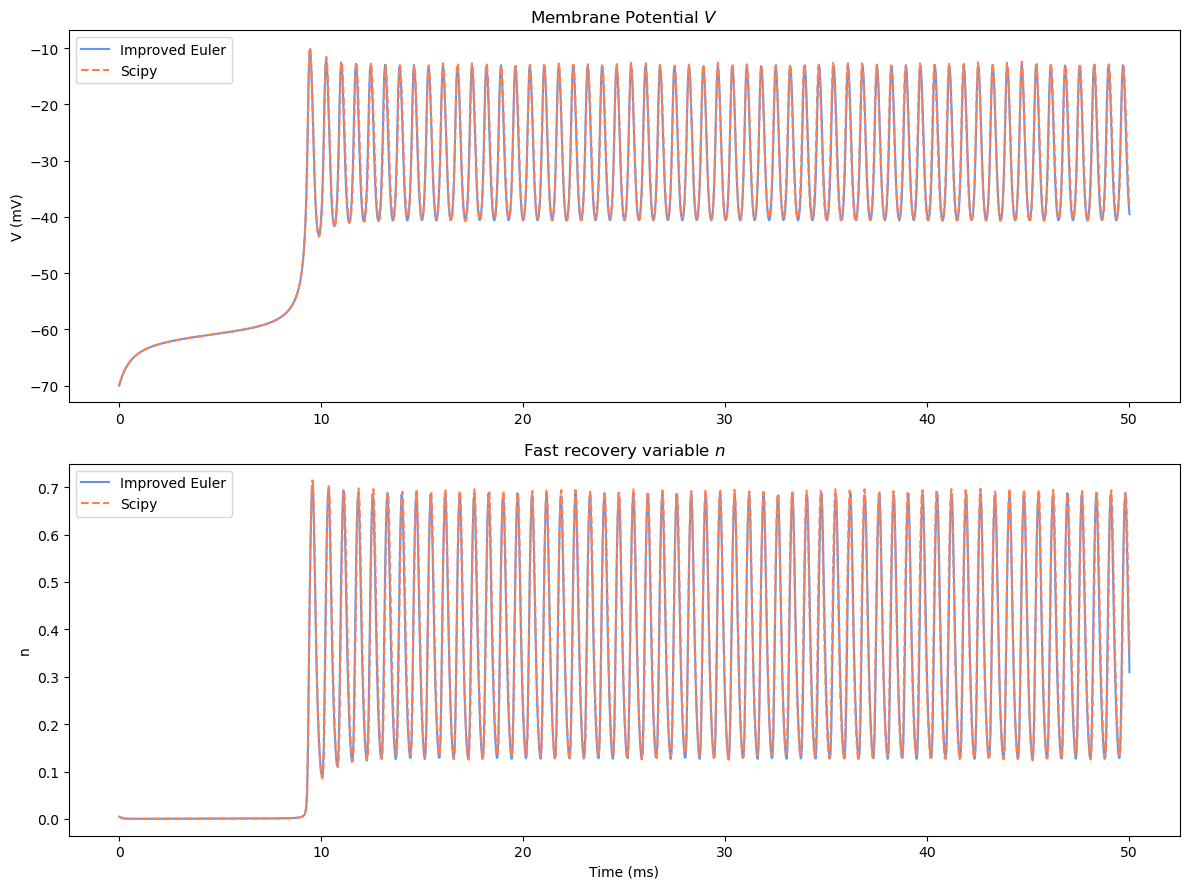

In [12]:
# initial conditions for 2-variable model
y0 = np.array([-70, 0.005])
t_min = 0
t_max = 50
n_s = 0

plot_trajectories_euler(t_min, t_max, y0, n_s)

#### 3-variable model

In [13]:
# initial conditions for 3-variable model
y0 = np.array([-70, 0.005, 0.005])
t_min = 0
t_max = 500

plot_trajectories_euler(t_min, t_max, y0)

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_31152/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


KeyboardInterrupt: 

Let's zoom in on the first and fourth burst:

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_3747/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


Optimal dt value: 0.0180
Mean absolute error in V: 1.0776
Mean absolute error in n: 0.0101
Mean absolute error in n_s: 0.0008


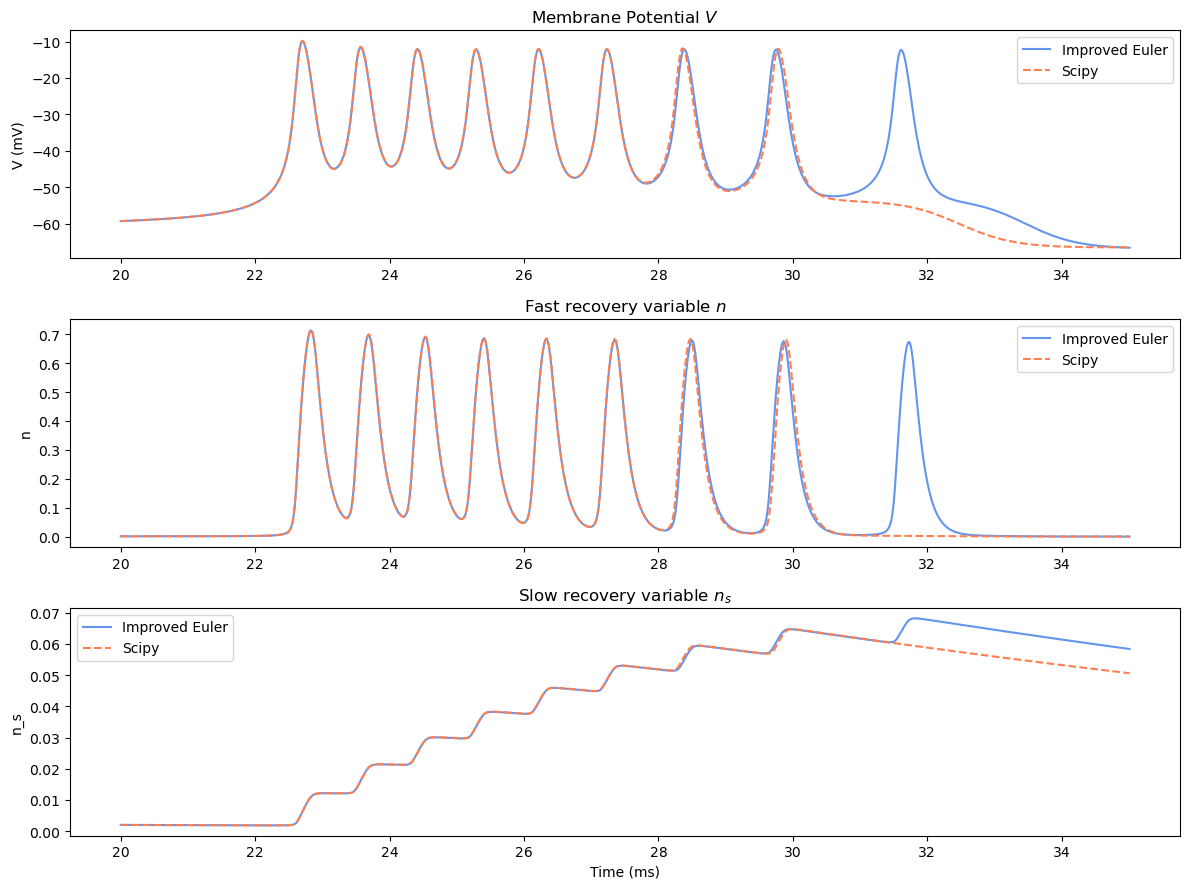

In [ ]:
# initial conditions for 3-variable model
y0 = np.array([-70, 0.005, 0.005])
t_min = 20
t_max = 35

plot_trajectories_euler(t_min, t_max, y0)

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_3747/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


Optimal dt value: 0.0500
Mean absolute error in V: 1.9230
Mean absolute error in n: 0.0242
Mean absolute error in n_s: 0.0022


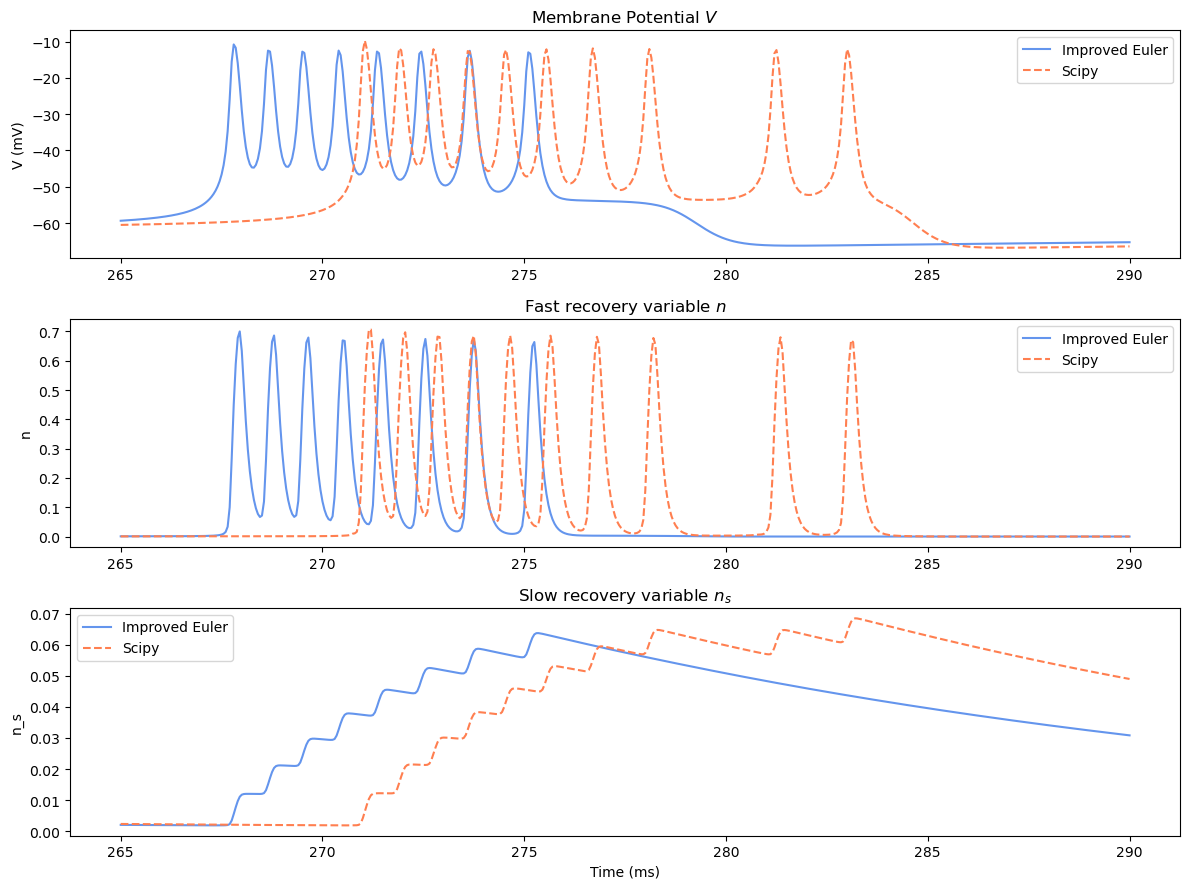

In [ ]:
# initial conditions for 3-variable model
y0 = np.array([-70, 0.005, 0.005])
t_min = 265
t_max = 290

plot_trajectories_euler(t_min, t_max, y0)

From here on, we will use the scipy solver.

### Finding threshold values of $n_s$

We want to find the interesting values of $n_s$. First we can look at the 3-variable model:

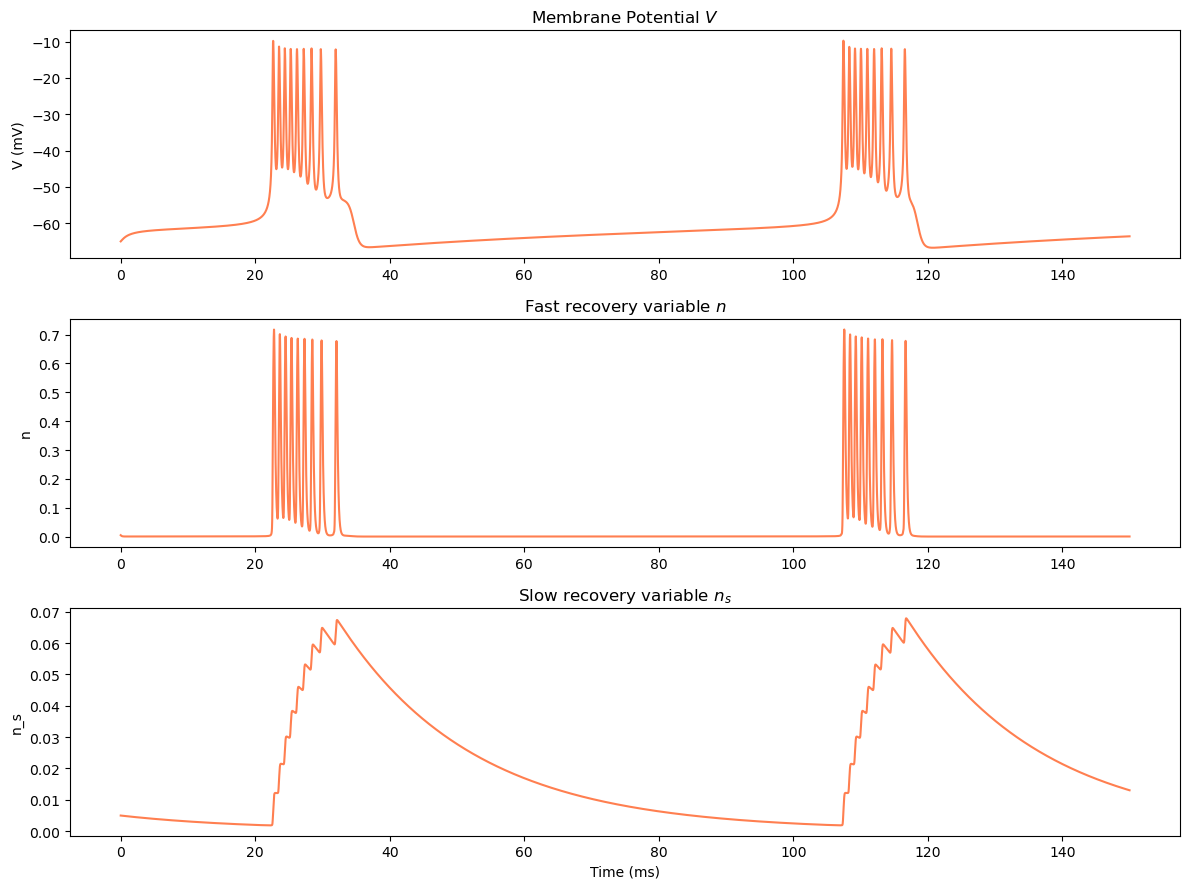

In [ ]:
# initial conditions for 3-variable model
y0 = np.array([-65, 0.005, 0.005])
t_min = 0
t_max = 150

plot_trajectories_scipy(t_min, t_max, y0)

The interesting value of ns appear to be close to 0 and close to 0.07. We can investigate this further using the 2-variable model and testing the threshold behavior of the model.

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_7558/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


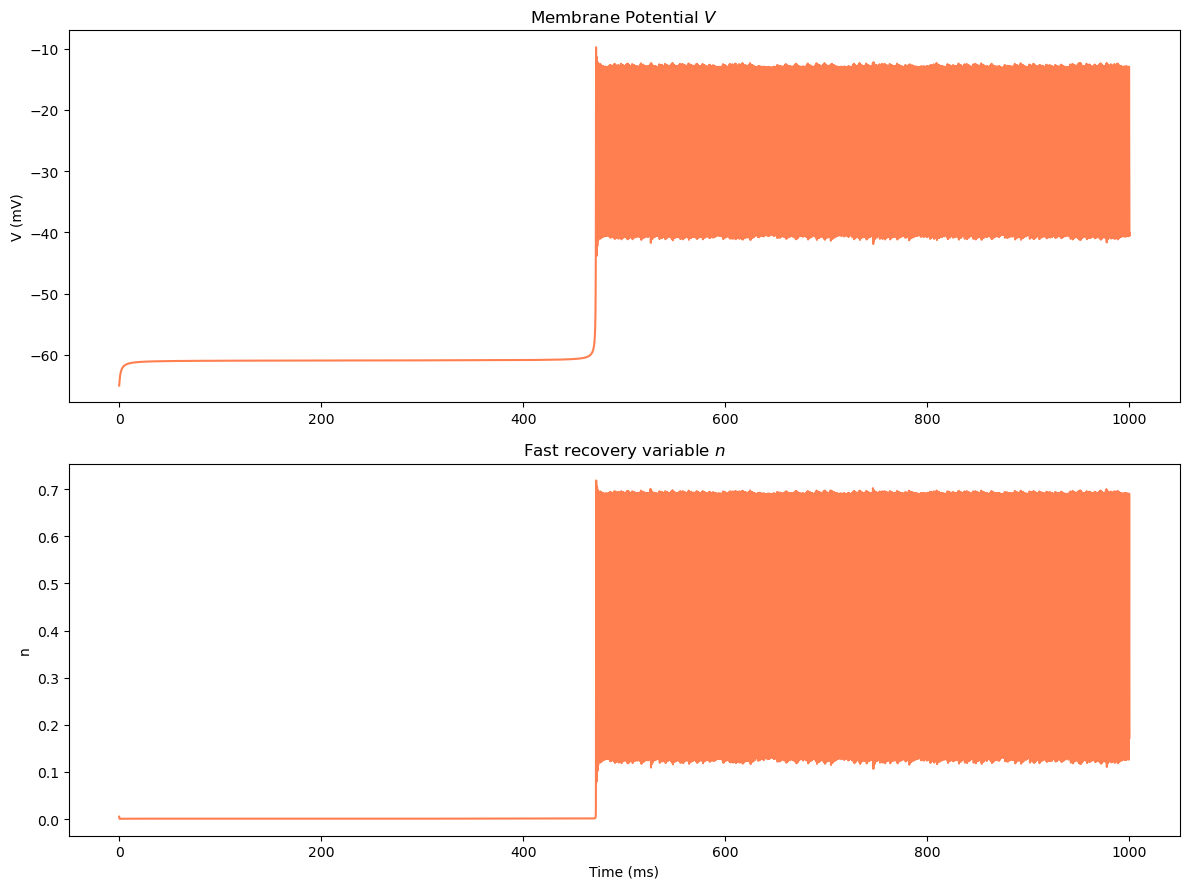

In [ ]:
# initial conditions for 2-variable model
y0 = np.array([-65, 0.005])
t_min = 0
t_max = 1000
n_s = 0.00350  ### set to 0.00351 to stop bursting

plot_trajectories_scipy(t_min, t_max, y0, n_s)

Decreasing $n_s$ below 0.00350 will cause the system to iniate bursting.

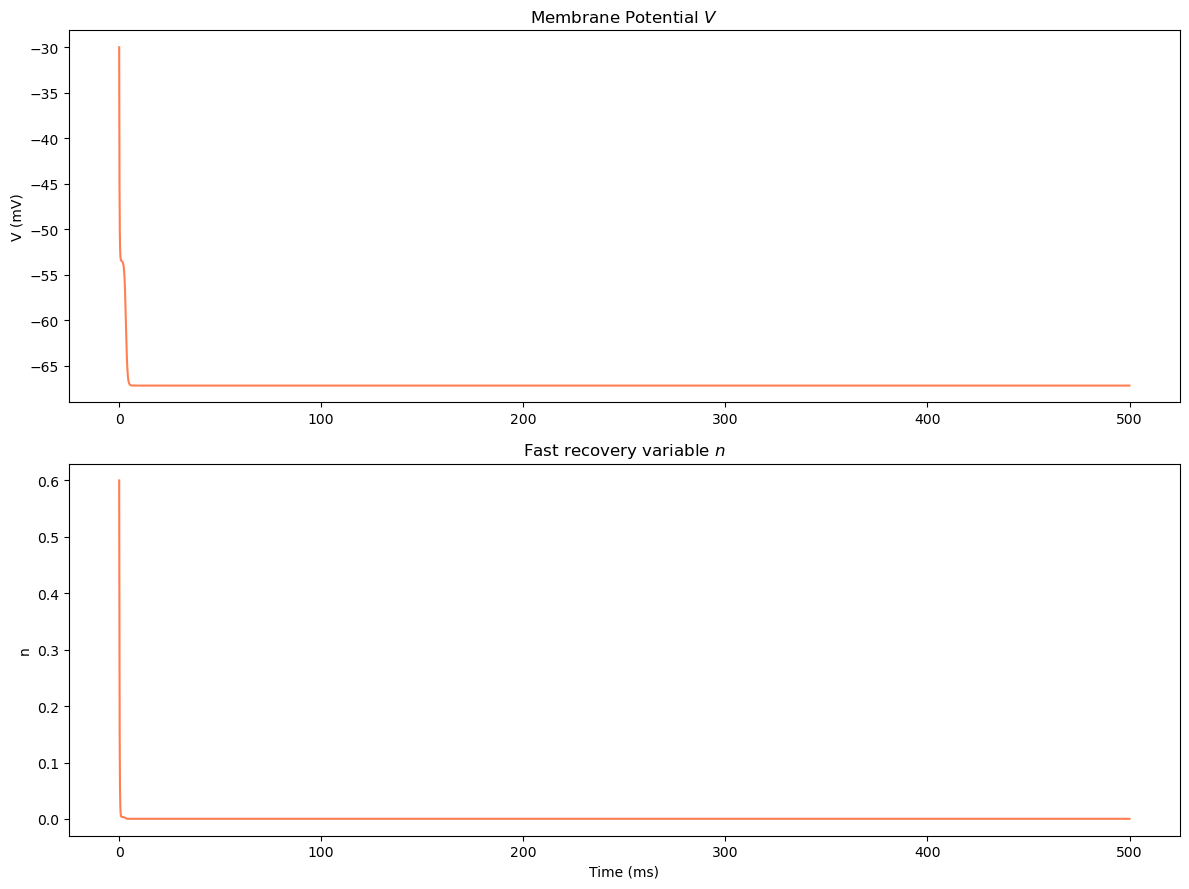

In [ ]:
# initial conditions for 2-variable model
y0 = np.array([-30, 0.6])
t_min = 0
t_max = 500
n_s = 0.0644 #change to 0.0645 to kill burst

plot_trajectories_scipy(t_min, t_max, y0, n_s)

Spiking stops when $n_s$ rises above $n_s = 0.0635$

### Phase plane analysis

- Plot trajectories of the neuron model in the phase plane for relevant values of ns (use the analytical work to guide you) together with the null clines and the fixed points.

V = -67.169986, n = 0.000217
V = -53.449555, n = 0.003369
V = -26.809122, n = 0.410518


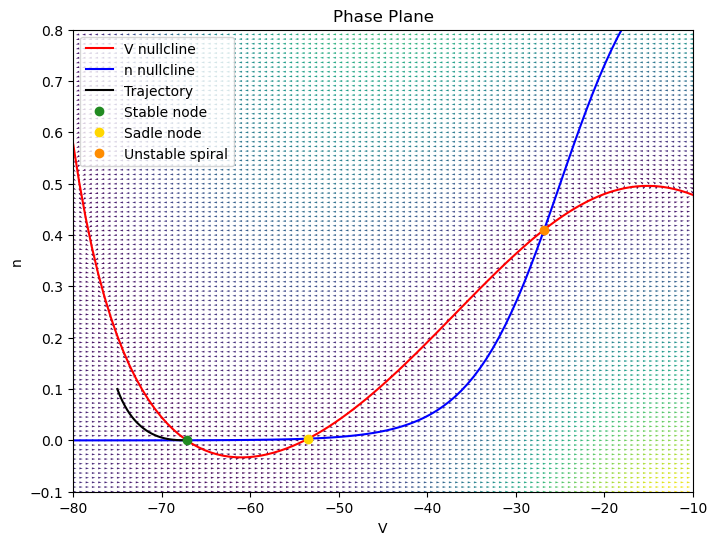

In [ ]:
n_s = 0.0645

#calculate trajectory
t = np.linspace(0, 10, 1000)  # Time points for trajectory calculation
y0 = [-75, 0.1]  # Initial condition for trajectory
trajectory = scipy_solution(model, t, y0, n_s)  # Calculate trajectory

fixed_points = calculate_fixed_points(n_s)
for point in fixed_points:
    V_fixed, n_fixed = point
    print(f"V = {V_fixed:.6f}, n = {n_fixed:.6f}")
    stability_analysis(V_fixed, n_fixed, n_s)

plot_phase_plane(fixed_points, n_s, trajectory)

V = -25.865800, n = 0.456818


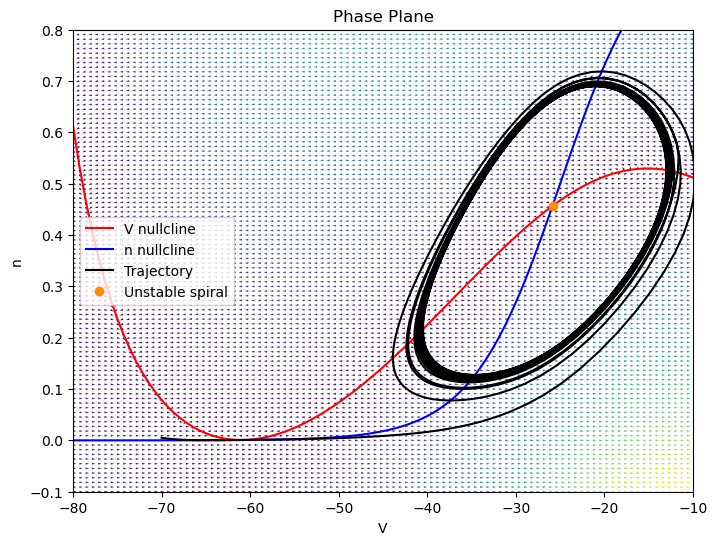

In [ ]:
n_s = 0.00350

#calculate trajectory
dt = 0.01
t = np.arange(0, 500, dt)  # Time points for trajectory calculation
y0 = [-70, 0.005]  # Initial condition for trajectory
trajectory = scipy_solution(model, t, y0, n_s)  # Calculate trajectory

fixed_points = calculate_fixed_points(n_s)
for point in fixed_points:
    V_fixed, n_fixed = point
    print(f"V = {V_fixed:.6f}, n = {n_fixed:.6f}")
    stability_analysis(V_fixed, n_fixed, n_s)

plot_phase_plane(fixed_points, n_s, trajectory)

V = -67.165316, n = 0.000218
V = -53.456215, n = 0.003364
V = -26.807527, n = 0.410595


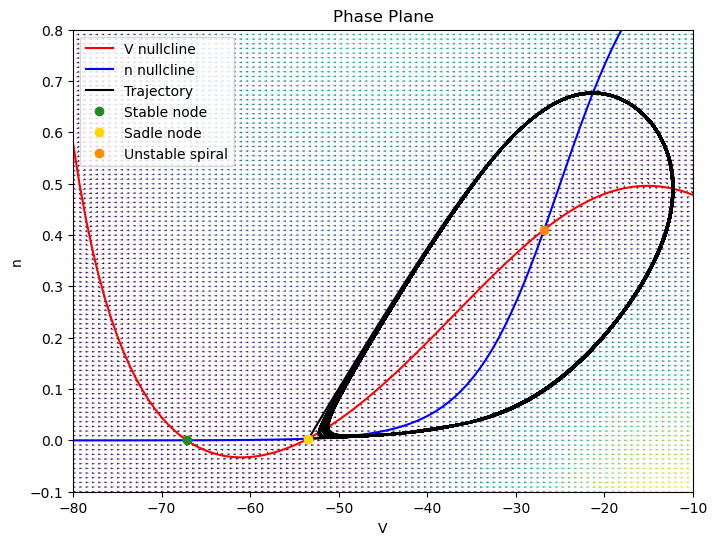

In [ ]:
n_s = 0.0644

#calculate trajectory
dt = 0.01
t = np.arange(0, 500, dt)  # Time points for trajectory calculation
y0 = [-30, 0.6]  # Initial condition for trajectory
trajectory = scipy_solution(model, t, y0, n_s)  # Calculate trajectory

fixed_points = calculate_fixed_points(n_s)
for point in fixed_points:
    V_fixed, n_fixed = point
    print(f"V = {V_fixed:.6f}, n = {n_fixed:.6f}")
    stability_analysis(V_fixed, n_fixed, n_s)

plot_phase_plane(fixed_points, n_s, trajectory)

V = -67.169986, n = 0.000217
V = -53.449555, n = 0.003369
V = -26.809122, n = 0.410518


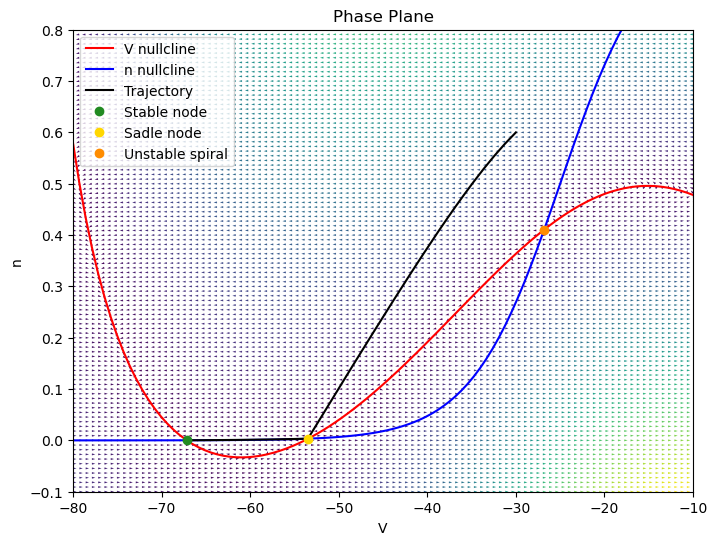

In [ ]:
n_s = 0.0645

#calculate trajectory
dt = 0.01
t = np.arange(0, 500, dt)  # Time points for trajectory calculation
y0 = [-30, 0.6]  # Initial condition for trajectory
trajectory = scipy_solution(model, t, y0, n_s)  # Calculate trajectory

fixed_points = calculate_fixed_points(n_s)
for point in fixed_points:
    V_fixed, n_fixed = point
    print(f"V = {V_fixed:.6f}, n = {n_fixed:.6f}")
    stability_analysis(V_fixed, n_fixed, n_s)

plot_phase_plane(fixed_points, n_s, trajectory)

### 2-variable model rates

- Determine numerically for which values of $n_s$ (as a constant) there are spikes and calculate their rate


/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_31152/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


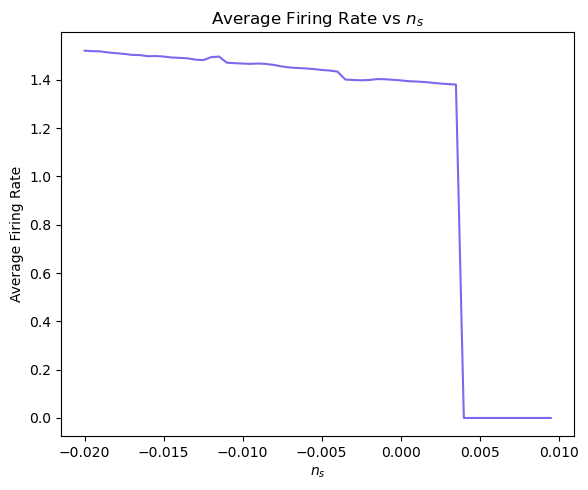

In [16]:
n_s_values = np.arange(-0.02,0.01,0.0005)
y0 = np.array([-70, 0.005])
t_max = 2000
dt = 0.01
spike_threshold = -30 
burst_threshold = 5 

burst_rates, average_spikes_per_burst_values, average_firing_rates = compute_metrics_vs_n_s(y0, t_max, dt, spike_threshold, burst_threshold, n_s_values)
plot_metrics_vs_n_s(n_s_values, average_firing_rates)

### 3-variable model rates

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_7558/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


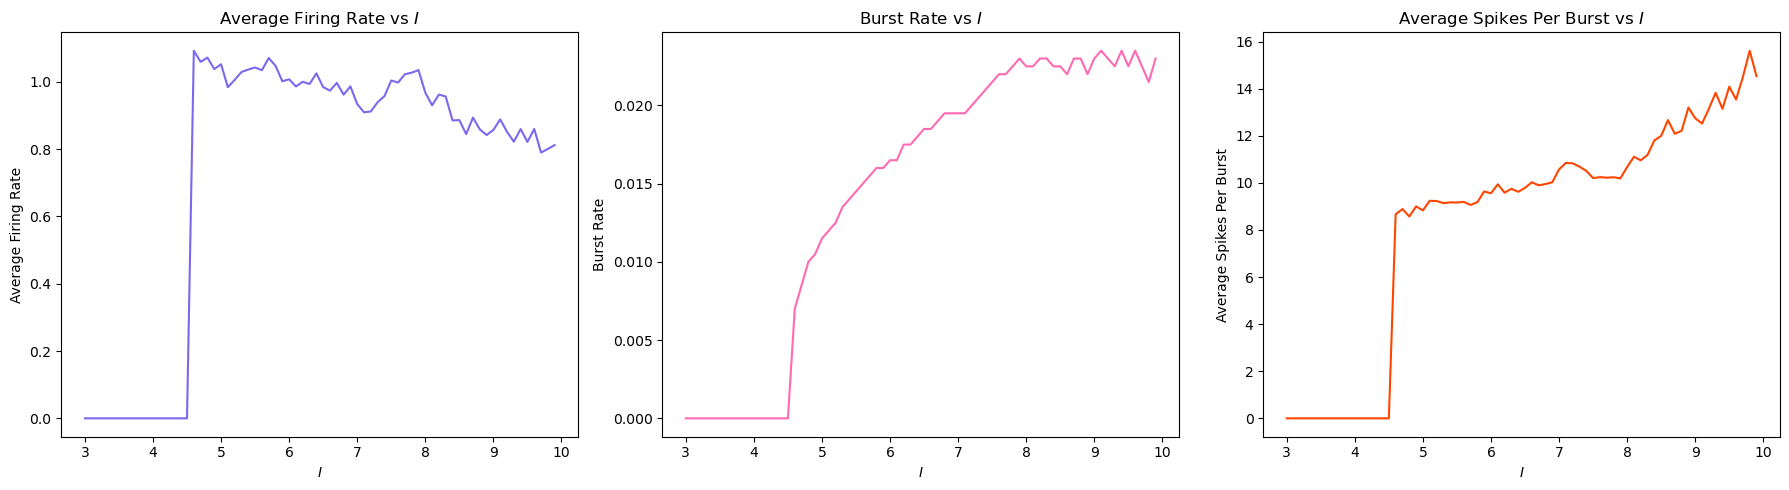

In [ ]:
I_values = np.arange(3, 10, .1)
y0 = np.array([-70, 0.005, 0.005])
t_max = 2000
dt = 0.01
spike_threshold = -30  
burst_threshold = 5  
burst_rates, average_spikes_per_burst_values, average_firing_rates = compute_metrics_vs_I(y0, t_max, dt, spike_threshold, burst_threshold, I_values)
plot_metrics_vs_I(I_values, burst_rates, average_spikes_per_burst_values, average_firing_rates)

### Chaos

As inspiration, we take this plot, which on its own might already classify as chaotic:

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_7558/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


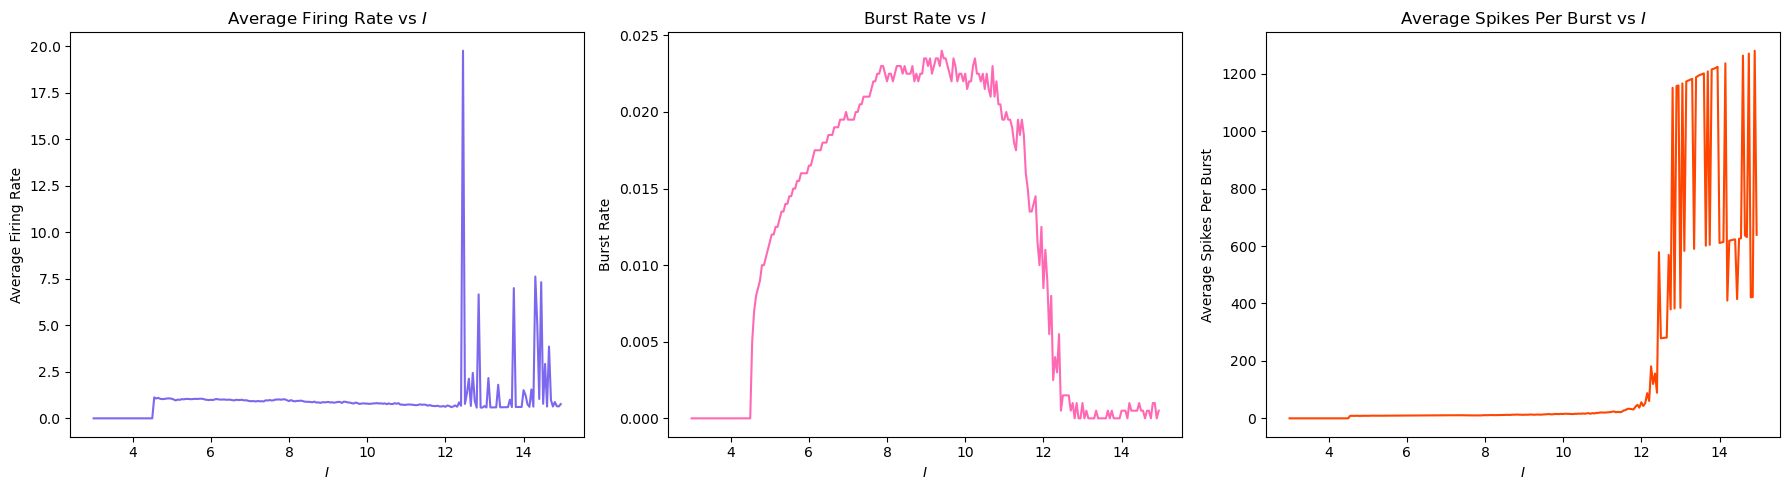

In [ ]:
I_values = np.arange(3, 15, 0.05)
y0 = np.array([-70, 0.005, 0.005])
t_max = 2000
dt = 0.01
spike_threshold = -30  
burst_threshold = 5  
burst_rates, average_spikes_per_burst_values, average_firing_rates = compute_metrics_vs_I(y0, t_max, dt, spike_threshold, burst_threshold, I_values)
plot_metrics_vs_I(I_values, burst_rates, average_spikes_per_burst_values, average_firing_rates)

Let's zoom in on the region of interest and increase the resolution

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_7558/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


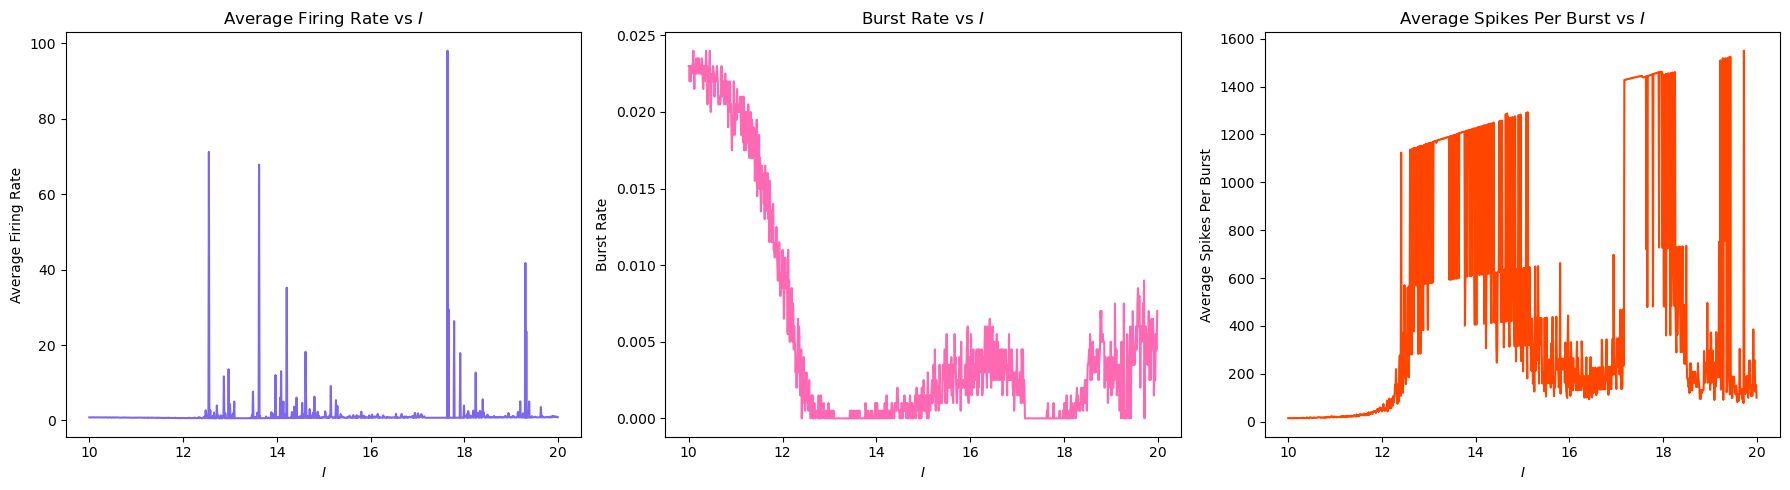

In [ ]:
I_values = np.arange(10, 20, 0.01)
y0 = np.array([-70, 0.005, 0.005])
t_max = 2000
dt = 0.01
spike_threshold = -30  
burst_threshold = 5  
burst_rates, average_spikes_per_burst_values, average_firing_rates = compute_metrics_vs_I(y0, t_max, dt, spike_threshold, burst_threshold, I_values)
plot_metrics_vs_I(I_values, burst_rates, average_spikes_per_burst_values, average_firing_rates)

and a bit lower resolution:

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_7558/378112477.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V_half - V) / k))


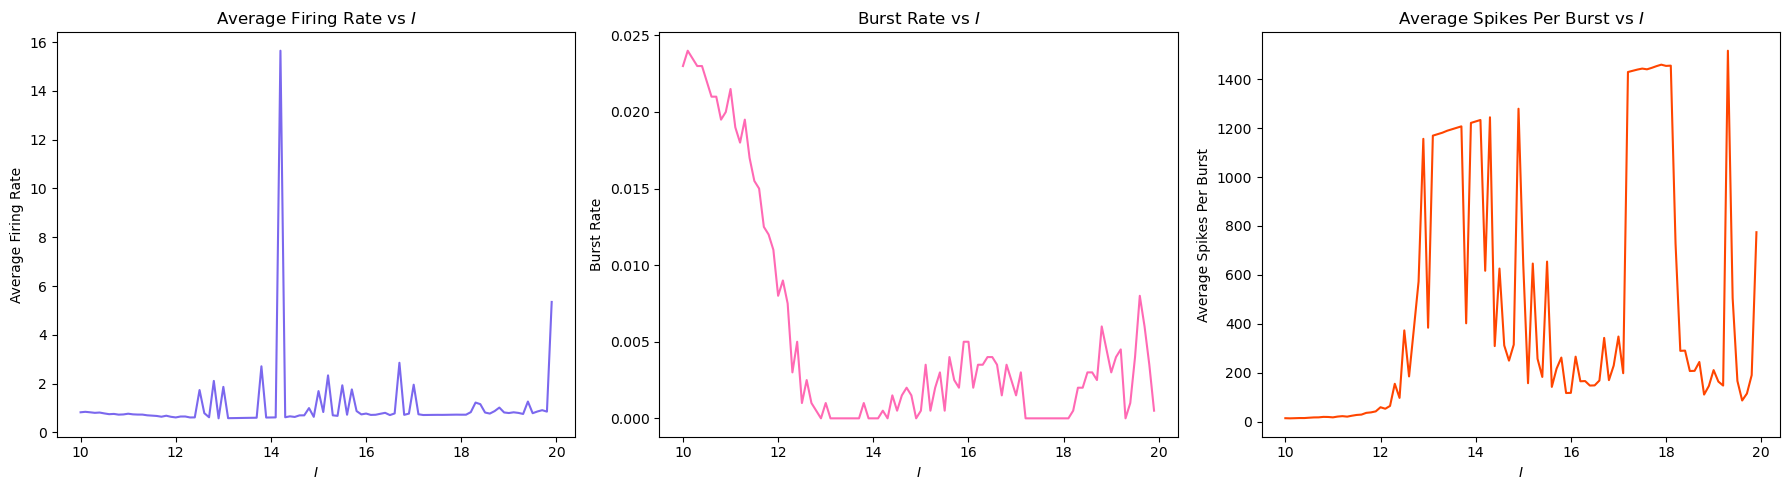

In [ ]:
I_values = np.arange(10, 20, 0.1)
y0 = np.array([-70, 0.005, 0.005])
t_max = 2000
dt = 0.01
spike_threshold = -30  
burst_threshold = 5  
burst_rates, average_spikes_per_burst_values, average_firing_rates = compute_metrics_vs_I(y0, t_max, dt, spike_threshold, burst_threshold, I_values)
plot_metrics_vs_I(I_values, burst_rates, average_spikes_per_burst_values, average_firing_rates)